In [1]:
# https://numpy.org/doc/stable/release.html
import numpy as np
import pandas as pd
import math
import os
import sys

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# plot
import matplotlib.pyplot as plt

%matplotlib inline

RANDOM_STATE = 1

src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    atomic_features_3D,
    hose_code,
)  # Some common methods I defined


pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

import pickle

pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning

In [2]:
data_path = os.path.join("..", "dataset", "Raw_PFAS 19F NMR spectra data.csv")

all_fluorinated_compounds = pd.read_csv(data_path, index_col=0)

# Train, validation, test dataset split
train_fluorinated_compounds, test_fluorinated_compounds = train_test_split(
    all_fluorinated_compounds, test_size=0.15, random_state=RANDOM_STATE, shuffle=True
)
train_fluorinated_compounds, vali_fluorinated_compounds = train_test_split(
    train_fluorinated_compounds, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)
print(
    f"Number of fluorinated_compounds in the train dataset: {train_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the validation dataset: {vali_fluorinated_compounds.shape[0]}"
)
print(
    f"Number of fluorinated_compounds in the test dataset: {test_fluorinated_compounds.shape[0]}"
)

Number of fluorinated_compounds in the train dataset: 439
Number of fluorinated_compounds in the validation dataset: 110
Number of fluorinated_compounds in the test dataset: 98


In [3]:
hose_vali_results_file_path = os.path.join(
    "..", "artifacts", "results", "results_validation_dataset_HOSE_based model.csv"
)
Hose_results = pd.read_csv(hose_vali_results_file_path, index_col=0)

xgboost_vali_results_2d_file_path = os.path.join(
    "..", "artifacts", "results", "XGBoost_2DFeatureSet_validation_dataset_sphere4.csv"
)
XGBoost_2D_validation_results = pd.read_csv(
    xgboost_vali_results_2d_file_path, index_col=0
)

xgboost_vali_results_3d_file_path = os.path.join(
    "..",
    "artifacts",
    "results",
    "XGBoost_descriptors from 5 spatially neighboring atoms_validation dataset fitting results.csv",
)
XGBoost_3D_validation_results = pd.read_csv(
    xgboost_vali_results_3d_file_path, index_col=0
)

ridge_vali_results_2d_file_path = os.path.join(
    "..", "artifacts", "results", "RidgeCV_2DFeatureSet_sphere5_valiDataset.csv"
)
RidgeCV_2D_validation_results = pd.read_csv(
    ridge_vali_results_2d_file_path, index_col=0
)

ridge_vali_results_3d_file_path = os.path.join(
    "..", "artifacts", "results", "RidgeCV_3DFeatureSet_neighbor5_valiDataset.csv"
)
RidgeCV_3D_validation_results = pd.read_csv(
    ridge_vali_results_3d_file_path, index_col=0
)

In [4]:
combined = pd.DataFrame()
combined = Hose_results.copy()
combined.rename(columns={"diff": "HOSE_vali"}, inplace=True)
combined = combined[["actual", "similarity_levels", "HOSE_vali"]]
combined["XGBoost_2D_vali"] = XGBoost_2D_validation_results["diff"]
combined["XGBoost_3D_vali"] = XGBoost_3D_validation_results["diff"]
combined["RidgeCV_3D_vali"] = RidgeCV_3D_validation_results["diff"]
combined["RidgeCV_2D_vali"] = RidgeCV_2D_validation_results["diff"]
combined.head(5)

,actual,similarity_levels,HOSE_vali,XGBoost_2D_vali,XGBoost_3D_vali,RidgeCV_3D_vali,RidgeCV_2D_vali
4_From_Review_316,-66.00,3,0.414286,0.345932,2.590851,1.786912,1.078848
5_From_Review_316,-66.00,3,0.414286,0.345932,2.590851,3.123173,1.078848
6_From_Review_316,-66.00,3,0.414286,0.345932,2.590851,1.552918,1.078848
7_SO3H_25,-115.13,6,0.750000,0.549543,0.189456,6.535691,2.907003
8_SO3H_25,-115.13,6,0.750000,0.549543,1.153453,4.672382,2.907003


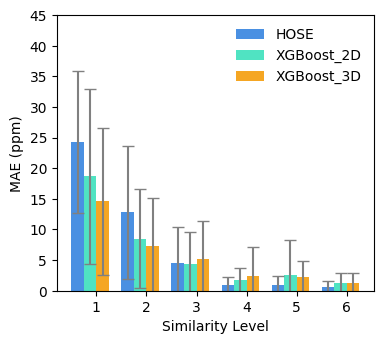

In [5]:
# Generate the bar plot
combined = combined[combined["similarity_levels"].isin([1, 2, 3, 4, 5, 6])]

grouped_df = combined.groupby("similarity_levels")[
    ["HOSE_vali", "XGBoost_2D_vali", "XGBoost_3D_vali"]
].agg(["mean", "std"])

# Extract mean and std values for each column
mean_values = grouped_df.xs("mean", axis=1, level=1)
std_values = grouped_df.xs("std", axis=1, level=1)

# Plot setup
cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm
width = 0.25  # Width of each bar

colors = ["#4A90E2", "#50E3C2", "#F5A623"]

# Positions for each column in the plot
x = np.arange(len(mean_values))

# Plot bars for each column
for i, (column, color) in enumerate(zip(mean_values.columns, colors)):
    ax.bar(
        x + i * width,
        mean_values[column],
        width=width,
        yerr=std_values[column],  # Adding error bars for standard deviation
        ecolor="grey",
        color=color,
        label=column,
        capsize=4,
    )

custom_labels = ["HOSE", "XGBoost_2D", "XGBoost_3D"]
ax.legend(labels=custom_labels, frameon=False)
# Customizing plot
ax.set_xlabel("Similarity Level")
ax.set_ylabel("MAE (ppm)")
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(mean_values.index)

ax.set_ylim([0, 45])
plt.tight_layout()
plt.show()

In [6]:
temp = combined[combined["similarity_levels"] == 1]
temp[["XGBoost_3D_vali", "HOSE_vali"]].describe()

,XGBoost_3D_vali,HOSE_vali
count,26.000000,26.000000
mean,14.621502,24.277607
std,11.977169,11.560038
min,0.452347,12.557986
25%,8.420078,16.557986
50%,12.458741,21.457986
75%,17.559096,35.557986
max,64.470734,49.442014


In [7]:
grouped_df

HOSE_vali            XGBoost_2D_vali             \
                        mean        std            mean        std   
similarity_levels                                                    
1                  24.277607  11.560038       18.679288  14.272052   
2                  12.823286  10.880975        8.514239   8.125075   
3                   4.512600   5.847644        4.310388   5.236182   
4                   0.989261   1.227795        1.721206   2.044304   
5                   0.931341   1.532593        2.602321   5.682302   
6                   0.654851   1.000780        1.236278   1.612361   

                  XGBoost_3D_vali             
                             mean        std  
similarity_levels                             
1                       14.621502  11.977169  
2                        7.299886   7.847535  
3                        5.226154   6.097981  
4                        2.474003   4.631659  
5                        2.204445   2.704391  
6                        1.290527   1.633222

The bar plot show the mean prediction error and standard deviation for each similarity levels and each model.

Apparently, for F atoms show high similarity to data in the training dataset (similarity level >= 4), results from HOSE model is more accurate. For F atoms show low similarity (similarity level < 4), results from XGBoost model is more accurate. 

(Hose would also be a good way to check if the data in our dataset is trust worthy.)

Based on above results, we tried to build a ensembled machine learning model which combine the prediction results of HOSE model and XGBoost_3D.

## Ensembled Model

In [8]:
file_path = os.path.join(
    "..", "artifacts", "results", "results_validation_dataset_HOSE_based model.csv"
)
Hose_results = pd.read_csv(file_path, index_col=0)

file_path = os.path.join(
    "..",
    "artifacts",
    "results",
    "XGBoost_descriptors from 5 spatially neighboring atoms_validation dataset fitting results.csv",
)
XGBoost_3D_validation_results = pd.read_csv(file_path, index_col=0)

combined_prediction = pd.DataFrame()
combined_prediction = Hose_results.copy()
combined_prediction.rename(
    columns={"prediction": "HOSE_model_prediction"}, inplace=True
)
combined_prediction = combined_prediction[
    ["actual", "similarity_levels", "HOSE_model_prediction"]
]
combined_prediction["XGBoost_3D_validation_prediction"] = XGBoost_3D_validation_results[
    "prediction"
]
combined_prediction.head(5)

,actual,similarity_levels,HOSE_model_prediction,XGBoost_3D_validation_prediction
4_From_Review_316,-66.00,3,-65.585714,-68.590850
5_From_Review_316,-66.00,3,-65.585714,-68.590850
6_From_Review_316,-66.00,3,-65.585714,-68.590850
7_SO3H_25,-115.13,6,-114.380000,-114.940544
8_SO3H_25,-115.13,6,-114.380000,-113.976550


In [9]:
ensembled_XGBoost3D_and_HOSE = []
for i, row in combined_prediction.iterrows():
    if row["similarity_levels"] >= 4:
        ensembled_XGBoost3D_and_HOSE.append(row["HOSE_model_prediction"])
    else:
        ensembled_XGBoost3D_and_HOSE.append(row["XGBoost_3D_validation_prediction"])

combined_prediction["ensembeled model"] = ensembled_XGBoost3D_and_HOSE
combined_prediction["ensembeled model_error"] = (
    combined_prediction["ensembeled model"] - combined_prediction["actual"]
)
combined_prediction["ensembeled model_error"] = combined_prediction[
    "ensembeled model_error"
].abs()
combined["ensembeled_model"] = combined_prediction["ensembeled model_error"]
combined

,actual,similarity_levels,HOSE_vali,XGBoost_2D_vali,XGBoost_3D_vali,RidgeCV_3D_vali,RidgeCV_2D_vali,ensembeled_model
4_From_Review_316,-66.00,3,0.414286,0.345932,2.590851,1.786912,1.078848,2.59085
5_From_Review_316,-66.00,3,0.414286,0.345932,2.590851,3.123173,1.078848,2.59085
6_From_Review_316,-66.00,3,0.414286,0.345932,2.590851,1.552918,1.078848,2.59085
7_SO3H_25,-115.13,6,0.750000,0.549543,0.189456,6.535691,2.907003,0.75000
8_SO3H_25,-115.13,6,0.750000,0.549543,1.153453,4.672382,2.907003,0.75000
...,...,...,...,...,...,...,...,...
0_Cl_4,-79.65,3,1.591264,3.054330,0.693513,0.200552,7.372407,0.69351
2_Cl_4,-79.65,3,1.591264,3.054330,0.859804,3.239173,7.372407,0.85980
3_Cl_4,-79.65,3,1.591264,3.054330,0.859804,3.194766,7.372407,0.85980
5_Cl_4,-120.25,2,1.437403,9.383057,2.913689,2.525369,9.643132,2.91369


## Plot prediction performance of the ensembled model

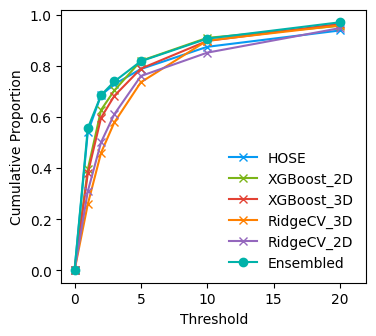

In [10]:
def plot_multi_prediction_performances(results_table):
    total_count = len(results_table)
    models = [
        "HOSE_vali",
        "XGBoost_2D_vali",
        "XGBoost_3D_vali",
        "RidgeCV_3D_vali",
        "RidgeCV_2D_vali",
        "ensembeled_model",
    ]
    colors = [
        "#069AF3",
        "#7CB518",
        "#E34234",
        "#FF8000",
        "C4",
        "#00B2A9",
    ]  # Colors for each model
    labels = [
        "HOSE",
        "XGBoost_2D",
        "XGBoost_3D",
        "RidgeCV_3D",
        "RidgeCV_2D",
        "Ensembled",
    ]
    cm = 1 / 2.54  # centimeters in inches
    fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

    for idx, diff in enumerate(models):
        (
            num_below_1,
            num_below_2,
            num_below_3,
            num_below_5,
            num_below_10,
            num_below_20,
        ) = (0, 0, 0, 0, 0, 0)
        for i in results_table[diff]:
            if i < 20:
                num_below_20 += 1
            if i < 10:
                num_below_10 += 1
            if i < 5:
                num_below_5 += 1
            if i < 3:
                num_below_3 += 1
            if i < 2:
                num_below_2 += 1
            if i < 1:
                num_below_1 += 1

        x = [0, 1, 2, 3, 5, 10, 20]
        y = [
            0,
            num_below_1,
            num_below_2,
            num_below_3,
            num_below_5,
            num_below_10,
            num_below_20,
        ]
        y = [val / total_count for val in y]

        if idx <= 4:
            ax.plot(x, y, marker="x", label=labels[idx], color=colors[idx])
            ax.set_xlabel("Threshold")
            ax.set_ylabel("Cumulative Proportion")
            # for i in range(len(x)):
            #     plt.annotate(f'({x[i]}, {y[i]:.2f})', (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='left')
        else:
            ax.plot(
                x,
                y,
                marker="o",
                label=labels[idx],
                color=colors[idx],
            )
            ax.set_xlabel("Threshold")
            ax.set_ylabel("Cumulative Proportion")

    ax.grid(False)
    ax.set_xlim([-1, 22])
    ax.legend(frameon=False)

    plt.show()


plot_multi_prediction_performances(combined)

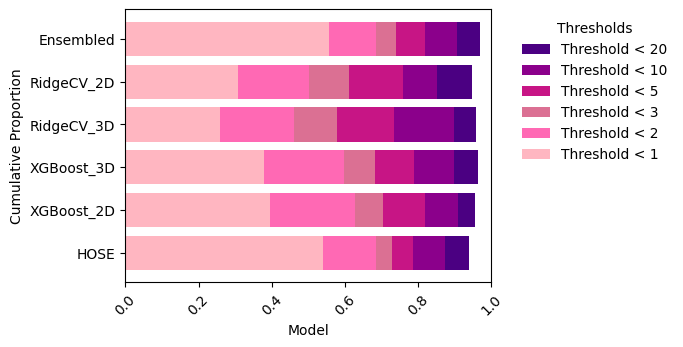

In [11]:
import matplotlib.pyplot as plt
import numpy as np


def plot_cumulative_stacked_bar(results_table):
    total_count = len(results_table)
    models = [
        "HOSE_vali",
        "XGBoost_2D_vali",
        "XGBoost_3D_vali",
        "RidgeCV_3D_vali",
        "RidgeCV_2D_vali",
        "ensembeled_model",
    ]
    model_labels = [
        "HOSE",
        "XGBoost_2D",
        "XGBoost_3D",
        "RidgeCV_3D",
        "RidgeCV_2D",
        "Ensembled",
    ]
    #     thresholds = [1, 2, 3, 5, 10, 20]
    thresholds = [20, 10, 5, 3, 2, 1]
    colors = [
        "#4B0082",
        "#8B008B",
        "#C71585",
        "#DB7093",
        "#FF69B4",
        "#FFB6C1",
    ]  # Colors for each threshold

    # Initialize cumulative proportions for each model
    cumulative_proportions = {model: [0] * len(thresholds) for model in models}

    # Calculate cumulative proportions for each model at each threshold
    for model in models:
        num_below_cumulative = [0] * len(thresholds)  # Initialize cumulative counts
        for value in results_table[model]:
            for i, threshold in enumerate(thresholds):
                if value < threshold:
                    num_below_cumulative[i] += 1
        # Convert counts to cumulative proportions
        cumulative_proportions[model] = [
            count / total_count for count in num_below_cumulative
        ]

    # Transpose cumulative proportions for plotting
    stacked_data = np.array([cumulative_proportions[model] for model in models])

    # Plotting
    cm = 1 / 2.54  # centimeters in inches
    fig, ax = plt.subplots(figsize=(12 * cm, 9 * cm))  # Adjust size as needed
    left = np.zeros(len(models))  # Initialize bottom to zero for each model

    # Plot cumulative stacked bars
    for i, (threshold, color) in enumerate(zip(thresholds, colors)):
        #         ax.bar(model_labels, stacked_data[:, i], bottom=bottom, label=f'Threshold < {threshold}', color=color)
        ax.barh(
            model_labels,
            stacked_data[:, i],
            left=left,
            label=f"Threshold < {threshold}",
            color=color,
        )
        bottom = stacked_data[
            :, i
        ]  # Update bottom to cumulative total for each threshold

    # Labels and formatting
    ax.set_xlabel("Model")
    ax.set_ylabel("Cumulative Proportion")
    ax.set_xlim(0, 1)
    ax.legend(
        title="Thresholds", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left"
    )

    plt.xticks(rotation=45)
    plt.show()


# Example call to the function
plot_cumulative_stacked_bar(combined)

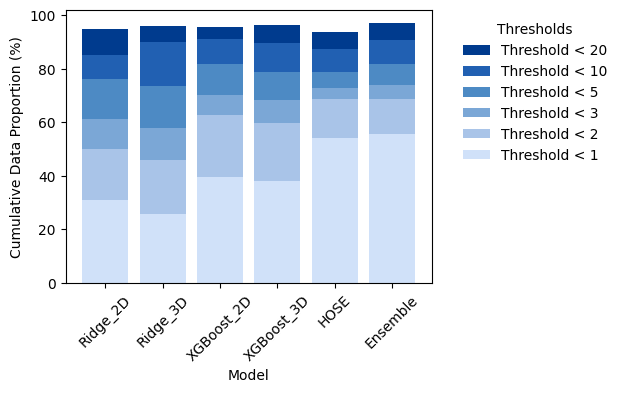

In [12]:
def plot_cumulative_stacked_bar(results_table):
    total_count = len(results_table)
    models = [
        "RidgeCV_2D_vali",
        "RidgeCV_3D_vali",
        "XGBoost_2D_vali",
        "XGBoost_3D_vali",
        "HOSE_vali",
        "ensembeled_model",
    ]
    model_labels = [
        "Ridge_2D",
        "Ridge_3D",
        "XGBoost_2D",
        "XGBoost_3D",
        "HOSE",
        "Ensemble",
    ]
    #     thresholds = [1, 2, 3, 5, 10, 20]
    #     colors = ['#FFB6C1', '#FF69B4', '#DB7093', '#C71585', '#8B008B', '#4B0082']  # Colors for each threshold
    thresholds = [20, 10, 5, 3, 2, 1]
    colors2 = [
        "#4B0082",
        "#8B008B",
        "#C71585",
        "#DB7093",
        "#FF69B4",
        "#FFB6C1",
    ]  # Colors for each threshold
    #     colors = ['#011F4B','#0B3D91','#03396C','#005B96', '#6497B1','#B3CDE3']
    colors = ["#003B8E", "#2160B2", "#4D8AC4", "#7BA7D6", "#A9C4E8", "#D0E1F9"]

    # Initialize cumulative proportions for each model
    cumulative_proportions = {model: [0] * len(thresholds) for model in models}

    # Calculate cumulative proportions for each model at each threshold
    for model in models:
        num_below_cumulative = [0] * len(thresholds)  # Initialize cumulative counts
        for value in results_table[model]:
            for i, threshold in enumerate(thresholds):
                if value < threshold:
                    num_below_cumulative[i] += 1
        # Convert counts to cumulative proportions
        cumulative_proportions[model] = [
            count / total_count for count in num_below_cumulative
        ]

    # Transpose cumulative proportions for plotting
    stacked_data = np.array([cumulative_proportions[model] for model in models])

    # Plotting
    cm = 1 / 2.54  # centimeters in inches
    fig, ax = plt.subplots(figsize=(12 * cm, 9 * cm))  # Adjust size as needed
    bottom = np.zeros(len(models))  # Initialize bottom to zero for each model

    # Plot cumulative stacked bars
    for i, (threshold, color) in enumerate(zip(thresholds, colors)):
        ax.bar(
            model_labels,
            stacked_data[:, i] * 100,
            bottom=bottom,
            label=f"Threshold < {threshold}",
            color=color,
        )
    #     for i, (threshold, color) in enumerate(zip(thresholds, colors)):
    #         ax.bar('Ensemble', stacked_data[-1, i], bottom=bottom, label=f'Threshold < {threshold}', color=color, edgecolor='C3', linewidth = 0.2)

    # Labels and formatting
    ax.set_xlabel("Model")
    ax.set_ylabel("Cumulative Data Proportion (%)")
    #     ax.set_ylim(0, 1)
    ax.legend(
        title="Thresholds", frameon=False, bbox_to_anchor=(1.05, 1), loc="upper left"
    )

    plt.xticks(rotation=45)
    #     print(cumulative_proportions)
    plt.show()


# Example call to the function
plot_cumulative_stacked_bar(combined)

In [13]:
hose_vali_results_file_path = os.path.join(
    "..", "artifacts", "results", "results_validation_dataset_HOSE_based model.csv"
)
Hose_results = pd.read_csv(hose_vali_results_file_path, index_col=0)

xgboost_vali_results_2d_file_path = os.path.join(
    "..", "artifacts", "results", "XGBoost_2DFeatureSet_validation_dataset_sphere4.csv"
)
XGBoost_2D_validation_results = pd.read_csv(
    xgboost_vali_results_2d_file_path, index_col=0
)

xgboost_vali_results_3d_file_path = os.path.join(
    "..",
    "artifacts",
    "results",
    "XGBoost_descriptors from 5 spatially neighboring atoms_validation dataset fitting results.csv",
)
XGBoost_3D_validation_results = pd.read_csv(
    xgboost_vali_results_3d_file_path, index_col=0
)

ridge_vali_results_2d_file_path = os.path.join(
    "..", "artifacts", "results", "RidgeCV_2DFeatureSet_sphere5_valiDataset.csv"
)
RidgeCV_2D_validation_results = pd.read_csv(
    ridge_vali_results_2d_file_path, index_col=0
)

ridge_vali_results_3d_file_path = os.path.join(
    "..", "artifacts", "results", "RidgeCV_3DFeatureSet_neighbor5_valiDataset.csv"
)
RidgeCV_3D_validation_results = pd.read_csv(
    ridge_vali_results_3d_file_path, index_col=0
)

Hose_results

,actual,prediction,diff,similarity_levels
4_From_Review_316,-66.00,-65.585714,0.414286,3
5_From_Review_316,-66.00,-65.585714,0.414286,3
6_From_Review_316,-66.00,-65.585714,0.414286,3
7_SO3H_25,-115.13,-114.380000,0.750000,6
8_SO3H_25,-115.13,-114.380000,0.750000,6
...,...,...,...,...
0_Cl_4,-79.65,-81.241264,1.591264,3
2_Cl_4,-79.65,-81.241264,1.591264,3
3_Cl_4,-79.65,-81.241264,1.591264,3
5_Cl_4,-120.25,-121.687403,1.437403,2


R2 = 0.9494017415658975
RMSE = 6.59
MAE = 3.08


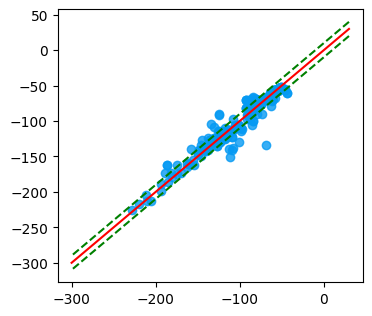

In [14]:
cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

ax.scatter(
    x=combined_prediction["actual"],
    y=combined_prediction["ensembeled model"],
    alpha=0.8,
    color="#069AF3",
)

ax.plot([30, -300], [30, -300], c="red")
ax.plot([30, -300], [40, -290], c="green", linestyle="dashed")
ax.plot([30, -300], [20, -310], c="green", linestyle="dashed")

combined_prediction = combined_prediction.dropna()
r2 = r2_score(combined_prediction["actual"], combined_prediction["ensembeled model"])
mse = mean_squared_error(
    combined_prediction["actual"], combined_prediction["ensembeled model"]
)
rmse = math.sqrt(mse)
mae = mean_absolute_error(
    combined_prediction["actual"], combined_prediction["ensembeled model"]
)
print(f"R2 = {r2}")
print(f"RMSE = {rmse:.2f}")
print(f"MAE = {mae:.2f}")

# Test Dataset

## HOSE Model

In [15]:
def getHOSEPredictionResults(HOSE_Code_database_file_path, test_fluorinated_compounds):
    HOSE_Code_database = pd.read_csv(HOSE_Code_database_file_path)
    # Transform column names to int where possible
    HOSE_Code_database.columns = [
        common.convert_column_name(name) for name in HOSE_Code_database.columns
    ]

    HOSE_codes_test = hose_code.getHoseCodeContent(test_fluorinated_compounds)

    # Get HOSE Code and corresponding 19F NMR values using train dataset
    sphere_dics = hose_code.getTrainDictionary_HOSE(HOSE_Code_database)

    HOSE_Code_database["NMR_Peaks"] = HOSE_Code_database["NMR_Peaks"].astype(float)

    # Get prediction results and corresponding similarity levels for the validation dataset
    prediction, similarity_levels = hose_code.HOSE_Model(
        sphere_dics, HOSE_codes_test, HOSE_Code_database["NMR_Peaks"].mean()
    )

    # Validation dataset
    results = hose_code.getResults_HOSE(prediction, similarity_levels, HOSE_codes_test)
    #     display(results)
    results = results.dropna(subset=["actual"])
    common.plot_prediction_performance(results, figure_title=None)
    common.show_results_scatter(results, figure_title=None)

    return results

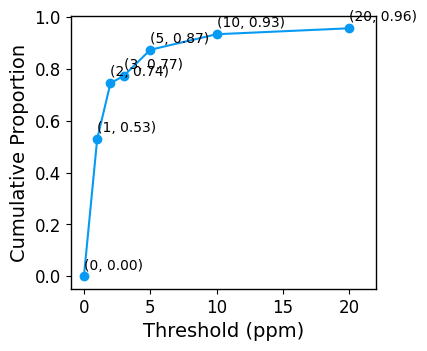

R2 = 0.94
RMSE = 7.90
MAE = 3.032169832877928


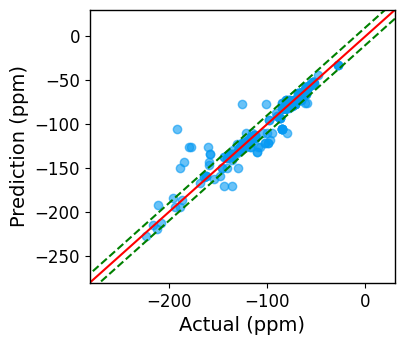

,actual,prediction,diff,similarity_levels
8_From_Review_201,-116.0,-116.000000,0.000000,4
9_From_Review_201,-116.0,-116.000000,0.000000,4
0_From_Review_282,-69.3,-72.840338,3.540338,2


In [16]:
file_path = os.path.join(
    "..", "artifacts", "temp", "HOSE_Code_database_from_train_dataset.csv"
)
test_fluorinated_compounds = test_fluorinated_compounds

HOSE_results_test = getHOSEPredictionResults(file_path, test_fluorinated_compounds)
HOSE_results_test.head(3)

## XGBoost

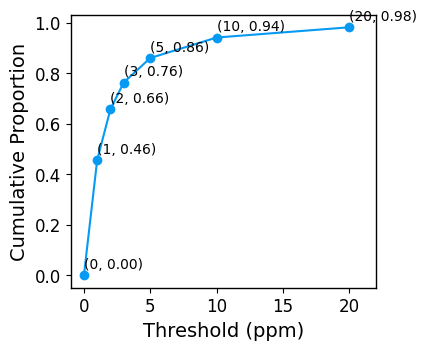

R2 = 0.97
RMSE = 5.09
MAE = 2.6956644540615184


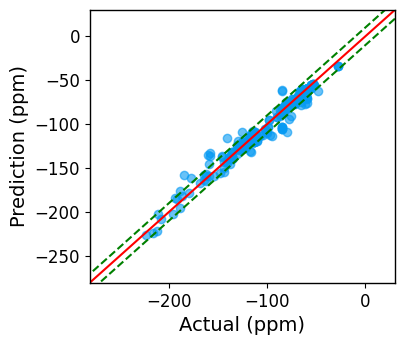

,actual,prediction,diff
8_From_Review_201,-116.0,-112.042603,3.957397
9_From_Review_201,-116.0,-112.042603,3.957397
0_From_Review_282,-69.3,-70.557236,1.257236


In [17]:
base_file_path = os.path.join("..", "artifacts", "models")

XGBoost_test_results = atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
    best_model_file_path=os.path.join(base_file_path, "xgboost_model_neighbor5.json"),
    columns_file_path=os.path.join(
        base_file_path, "column_names_neighbor5_xgboost.pkl"
    ),
    neighbor_num=5,
    test_dataset=test_fluorinated_compounds,
)
XGBoost_test_results.head(3)

## Ensembled Model

In [18]:
ensemble = pd.DataFrame()
ensemble["actual"] = HOSE_results_test["actual"]
ensemble["similarity_levels"] = HOSE_results_test["similarity_levels"]
ensemble["HOSE_model"] = HOSE_results_test["prediction"]
ensemble["XGBoost_3D_model"] = XGBoost_test_results["prediction"]
ensembled_XGBoost3D_and_HOSE = []
for i, row in ensemble.iterrows():
    if row["similarity_levels"] >= 4:
        ensembled_XGBoost3D_and_HOSE.append(row["HOSE_model"])
    else:
        ensembled_XGBoost3D_and_HOSE.append(row["XGBoost_3D_model"])

ensemble["ensembeled_model"] = ensembled_XGBoost3D_and_HOSE

file_path = os.path.join(
    "..",
    "artifacts",
    "results",
    "Final_performance_comparision_among_models_using_the_test_dataset.csv",
)
ensemble.to_csv(file_path, encoding="utf-8")

ensemble

,actual,similarity_levels,HOSE_model,XGBoost_3D_model,ensembeled_model
8_From_Review_201,-116.0,4,-116.000000,-112.042603,-116.000000
9_From_Review_201,-116.0,4,-116.000000,-112.042603,-116.000000
0_From_Review_282,-69.3,2,-72.840338,-70.557236,-70.557236
2_From_Review_282,-69.3,2,-72.840338,-70.557236,-70.557236
3_From_Review_282,-69.3,2,-72.840338,-70.557236,-70.557236
...,...,...,...,...,...
3_From_Review_458,-143.9,3,-137.574000,-149.288864,-149.288864
5_From_Review_458,-164.4,4,-160.060000,-163.700180,-160.060000
7_From_Review_458,-159.1,5,-146.645000,-159.207336,-146.645000
9_From_Review_458,-164.4,4,-160.060000,-158.166641,-160.060000


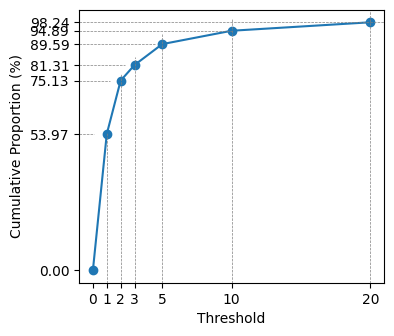

In [19]:
ensemble["diff_ensemble"] = (ensemble["actual"] - ensemble["ensembeled_model"]).abs()
total_count = len(ensemble)

cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))

num_below_1, num_below_2, num_below_3, num_below_5, num_below_10, num_below_20 = (
    0,
    0,
    0,
    0,
    0,
    0,
)
for i in ensemble["diff_ensemble"]:
    if i < 20:
        num_below_20 += 1
    if i < 10:
        num_below_10 += 1
    if i < 5:
        num_below_5 += 1
    if i < 3:
        num_below_3 += 1
    if i < 2:
        num_below_2 += 1
    if i < 1:
        num_below_1 += 1

x = [0, 1, 2, 3, 5, 10, 20]
y = [0, num_below_1, num_below_2, num_below_3, num_below_5, num_below_10, num_below_20]
y = [100 * val / total_count for val in y]

ax.plot(x, y, marker="o")

for i in range(len(x)):
    # plt.annotate(f'({x[i]}, {y[i]:.0f}%)', (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha='left')

    # Draw vertical and horizontal lines
    ax.axvline(
        x=x[i], ymin=0, ymax=y[i] / max(y), color="grey", linestyle="--", linewidth=0.5
    )
    ax.axhline(
        y=y[i], xmin=0, xmax=x[i] / max(x), color="grey", linestyle="--", linewidth=0.5
    )

# Set the x and y ticks to match the data points
ax.set_xticks(x)
ax.set_yticks(y)

ax.set_xlabel("Threshold")
ax.set_ylabel("Cumulative Proportion (%)")
ax.set_xlim([-1, 21])

plt.show()

R2 = 0.9764556915743129
RMSE = 4.79
Mean Absolute Error: 2.2380764386576044


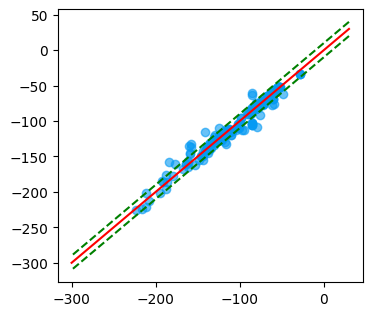

In [20]:
cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))

ax.scatter(
    x=ensemble["actual"], y=ensemble["ensembeled_model"], alpha=0.6, color="#069AF3"
)

ax.plot([30, -300], [30, -300], c="red")
ax.plot([30, -300], [40, -290], c="green", linestyle="dashed")
ax.plot([30, -300], [20, -310], c="green", linestyle="dashed")
r2 = r2_score(ensemble["actual"], ensemble["ensembeled_model"])
mse = mean_squared_error(ensemble["actual"], ensemble["ensembeled_model"])
rmse = math.sqrt(mse)
mae = mean_absolute_error(ensemble["actual"], ensemble["ensembeled_model"])

print(f"R2 = {r2}")
print(f"RMSE = {rmse:.2f}")
print("Mean Absolute Error:", mae)

## Error Analysis

In [21]:
test_dataset = ensemble[["actual", "ensembeled_model", "similarity_levels"]].copy()
test_dataset["ensembeled_model"] = (
    test_dataset["ensembeled_model"] - test_dataset["actual"]
).abs()

test_dataset

,actual,ensembeled_model,similarity_levels
8_From_Review_201,-116.0,0.000000,4
9_From_Review_201,-116.0,0.000000,4
0_From_Review_282,-69.3,1.257236,2
2_From_Review_282,-69.3,1.257236,2
3_From_Review_282,-69.3,1.257236,2
...,...,...,...
3_From_Review_458,-143.9,5.388864,3
5_From_Review_458,-164.4,4.340000,4
7_From_Review_458,-159.1,12.455000,5
9_From_Review_458,-164.4,4.340000,4


In [22]:
test_and_validation_results = pd.concat(
    [test_dataset, combined[["actual", "ensembeled_model", "similarity_levels"]]],
    axis=0,
)

# Group the data by 'similarity_levels'
grouped_1 = test_and_validation_results[
    test_and_validation_results["similarity_levels"] == 1
]
grouped_2 = test_and_validation_results[
    test_and_validation_results["similarity_levels"] == 2
]
grouped_3 = test_and_validation_results[
    test_and_validation_results["similarity_levels"] == 3
]
grouped_4 = test_and_validation_results[
    test_and_validation_results["similarity_levels"] == 4
]
grouped_5 = test_and_validation_results[
    test_and_validation_results["similarity_levels"] == 5
]
grouped_6 = test_and_validation_results[
    test_and_validation_results["similarity_levels"] == 6
]
grouped_1.describe().drop(["actual", "similarity_levels"], axis=1).drop(["count"])

,ensembeled_model
mean,15.139571
std,10.870382
min,0.452350
25%,11.097460
50%,15.505090
75%,18.593710
max,64.470730


In [23]:
grouped_6.describe().drop(["actual", "similarity_levels"], axis=1).drop(["count"])

,ensembeled_model
mean,0.626144
std,0.899342
min,0.000000
25%,0.180313
50%,0.397550
75%,0.870000
max,11.650000


For F atoms with different similarity levels compared to those in the training dataset, the possible error ranges vary.

The table below outlines the error range for each similarity level:

**Use Only Validation Dataset Results**
* Similarity level 6: Predictions are likely (around 75%) to deviate by less than **0.89 ppm** from the ground truth.
* Similarity level 5: Predictions are likely (around 75%) to deviate by less than **1.28 ppm** from the ground truth.
* Similarity level 4: Predictions are likely (around 75%) to deviate by less than **1.00 ppm** from the ground truth.
* Similarity level 3: Predictions are likely (around 75%) to deviate by less than **4.12 ppm** from the ground truth.
* Similarity level 2: Predictions are likely (around 75%) to deviate by less than **7.36 ppm** from the ground truth.
* Similarity level 1: Predictions are likely (around 75%) to deviate by less than **6.81 ppm** from the ground truth.

**Use Both Validation and Test Dataset Results**
* Similarity level 6: Predictions are likely (around 75%) to deviate by less than **0.89 ppm** from the ground truth.
* Similarity level 5: Predictions are likely (around 75%) to deviate by less than **1.05 ppm** from the ground truth.
* Similarity level 4: Predictions are likely (around 75%) to deviate by less than **1.53 ppm** from the ground truth.
* Similarity level 3: Predictions are likely (around 75%) to deviate by less than **5.05 ppm** from the ground truth.
* Similarity level 2: Predictions are likely (around 75%) to deviate by less than **6.91 ppm** from the ground truth.
* Similarity level 1: Predictions are likely (around 75%) to deviate by less than **11.88 ppm** from the ground truth.

# Plot NMR spectra

In [24]:
file_path = os.path.join(
    "..",
    "artifacts",
    "results",
    "Final_performance_comparision_among_models_using_the_test_dataset.csv",
)
ensemble = pd.read_csv(file_path, index_col=0)

In [25]:
def safe_split(index_value):
    parts = index_value.split("_", 1)
    if len(parts) == 2:
        return parts
    elif len(parts) == 1:
        return [parts[0], None]  # Only one part, return None for the second
    else:
        return [None, None]  # No parts, return None for both


split_values = [safe_split(idx) for idx in ensemble.index]

# Create new columns from the split values
ensemble["atom_index"] = [val[0] for val in split_values]
ensemble["fluorinated_compounds"] = [val[1] for val in split_values]
ensemble

,actual,similarity_levels,HOSE_model,XGBoost_3D_model,ensembeled_model,atom_index,fluorinated_compounds
8_From_Review_201,-116.0,4,-116.000000,-112.042600,-116.000000,8,From_Review_201
9_From_Review_201,-116.0,4,-116.000000,-112.042600,-116.000000,9,From_Review_201
0_From_Review_282,-69.3,2,-72.840338,-70.557236,-70.557236,0,From_Review_282
2_From_Review_282,-69.3,2,-72.840338,-70.557236,-70.557236,2,From_Review_282
3_From_Review_282,-69.3,2,-72.840338,-70.557236,-70.557236,3,From_Review_282
...,...,...,...,...,...,...,...
3_From_Review_458,-143.9,3,-137.574000,-149.288860,-149.288864,3,From_Review_458
5_From_Review_458,-164.4,4,-160.060000,-163.700180,-160.060000,5,From_Review_458
7_From_Review_458,-159.1,5,-146.645000,-159.207340,-146.645000,7,From_Review_458
9_From_Review_458,-164.4,4,-160.060000,-158.166640,-160.060000,9,From_Review_458


In [26]:
def plot_test_results(fluorinated_compounds, results):
    """
    Parameters
    ----------
    fluorinated_compounds: String
        PFAS name/acronym

    results: DataFrame
        Index: PFAS name/acronym
        Columns: Atom index
        Values: 19F NMR shift values

    """
    plt.figure(figsize=(4, 3))

    # Apply the safe_split function to the index

    real_PFAS_spectra_df = results[["fluorinated_compounds", "atom_index", "actual"]]
    real_PFAS_spectra_df = real_PFAS_spectra_df.pivot(
        index="fluorinated_compounds", columns="atom_index", values="actual"
    )

    predicted_PFAS_spectra_df = results[
        ["fluorinated_compounds", "atom_index", "ensembeled_model"]
    ]
    predicted_PFAS_spectra_df = predicted_PFAS_spectra_df.pivot(
        index="fluorinated_compounds", columns="atom_index", values="ensembeled_model"
    )

    # Get actual and predicted value counts
    actual = real_PFAS_spectra_df.loc[fluorinated_compounds, :].value_counts()
    predict = predicted_PFAS_spectra_df.loc[fluorinated_compounds, :].value_counts()

    # Plot actual values (blue, upward)
    plt.vlines(actual.index, ymin=0, ymax=actual.values, color="b", label="Actual")

    # Plot predicted values (red, downward)
    plt.vlines(
        predict.index, ymin=0, ymax=-predict.values, color="r", label="Prediction"
    )

    # Assign similarity levels and annotate
    temp = results[results["fluorinated_compounds"] == fluorinated_compounds]
    for i, j in zip(predict.index, -predict.values):
        similarity_level = temp[temp["ensembeled_model"] == i]["similarity_levels"]
        if not similarity_level.empty:
            plt.text(
                i,
                j * 1.15,
                similarity_level.iloc[0],
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
            )

    # Plot the zero line (black)
    plt.axhline(0, color="k")

    # Set plot limits
    x_min = min(actual.index.min(), predict.index.min()) - 10
    x_max = max(actual.index.max(), predict.index.max()) + 10
    y_max = max(actual.values.max(), predict.values.max()) + 0.2
    plt.xlim([x_min, x_max])
    plt.ylim([-y_max, y_max])

    # Add labels and legend
    plt.xlabel(r"$^{19}$F NMR shift")
    plt.yticks([])  # Remove y-axis tick labels
    # plt.legend(frameon=False, loc = (0.2, 0.8))

    # Show the plot
    plt.show()
    print(
        "Most possible (75%) prediction error for various confidence levels:\n"
        "6: 0.89 ppm\n"
        "5: 1.05 ppm\n"
        "4: 1.53 ppm\n"
        "3: 5.05 ppm\n"
        "2: 6.91 ppm\n"
        "1: 11.88 ppm"
    )

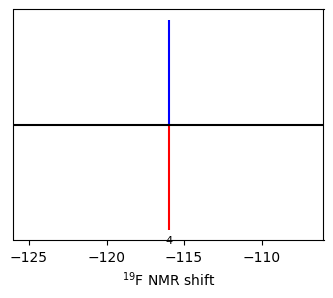

Most possible (75%) prediction error for various confidence levels:
6: 0.89 ppm
5: 1.05 ppm
4: 1.53 ppm
3: 5.05 ppm
2: 6.91 ppm
1: 11.88 ppm


In [27]:
plot_test_results("From_Review_201", ensemble)

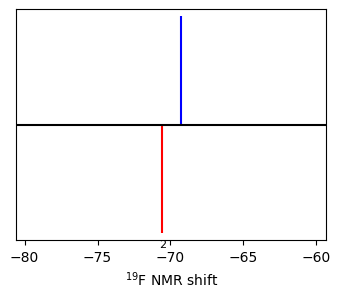

Most possible (75%) prediction error for various confidence levels:
6: 0.89 ppm
5: 1.05 ppm
4: 1.53 ppm
3: 5.05 ppm
2: 6.91 ppm
1: 11.88 ppm


In [28]:
plot_test_results("From_Review_282", ensemble)

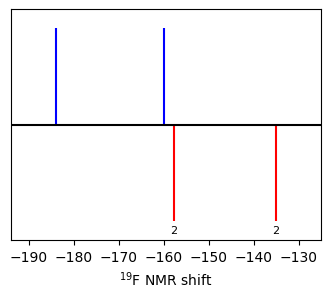

Most possible (75%) prediction error for various confidence levels:
6: 0.89 ppm
5: 1.05 ppm
4: 1.53 ppm
3: 5.05 ppm
2: 6.91 ppm
1: 11.88 ppm


In [29]:
plot_test_results("From_Review_155", ensemble)

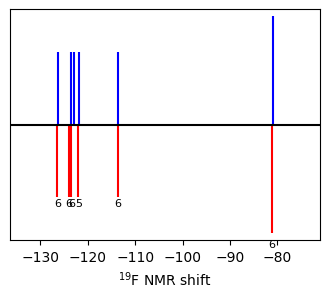

Most possible (75%) prediction error for various confidence levels:
6: 0.89 ppm
5: 1.05 ppm
4: 1.53 ppm
3: 5.05 ppm
2: 6.91 ppm
1: 11.88 ppm


In [30]:
plot_test_results("acrylates_2", ensemble)

In [31]:
ensemble["fluorinated_compounds"].unique()

array(['From_Review_201', 'From_Review_282', 'From_Review_470',
       'From_Review_182', 'From_Review_343', 'From_Review_339',
       'From_Review_381', 'From_Review_413', 'other_2', 'From_Review_155',
       'From_Review_16', 'acrylates_2', 'From_Review_483',
       'From_Review_281', 'aromatics_7', 'I_3', 'From_Review_122',
       'From_Review_192', 'From_Review_60', 'ethers_4', 'SO3H_12',
       'From_Review_468', 'From_Review_321', 'From_Review_279',
       'olefins_2', 'From_Review_130', 'From_Review_451', 'ethers_8',
       'From_Review_243', 'From_Review_111', 'From_Review_368', 'COOH_14',
       'From_Review_438', 'From_Review_355', 'From_Review_297',
       'other_10', 'From_Review_309', 'From_Review_174',
       'From_Review_172', 'I_6', 'SO3H_13', 'From_Review_225', 'other_5',
       'From_Review_160', 'ethers_1', 'alkanes_4', 'From_Review_247',
       'From_Review_374', 'other_11', 'From_Review_114',
       'From_Review_357', 'From_Review_32', 'Short_2', 'From_Review_373',